In [1]:
import math
import torch
import torch.nn as nn
from torch import Tensor
import torch.nn.functional as F
import numpy as np
from typing import Optional, Tuple
import os
import copy
import time

from torch.autograd import Variable
from torch.nn.utils import clip_grad_norm_

In [2]:
class Embeddings(nn.Module):
  def __init__(self, vocab_num, d_model):
    super(Embeddings,self).__init__()
    self.emb = nn.Embedding(vocab_num,d_model)
    self.d_model = d_model
  def forward(self, x):

    return self.emb(x) * math.sqrt(self.d_model)

In [3]:
# class PositionalEncoding(nn.Module):

#     def __init__(self, emb_dim, seq_len):
#         super().__init__()

#         self.encoding = torch.zeros(seq_len, emb_dim)
#         self.encoding.requires_grad = False

#         pos = torch.arange(0,seq_len).float().unsqueeze(dim=1)
#         _2i = torch.arange(0,emb_dim,step=2).float()

#         # self.encoding = (sequence_length, hidden_size)
#         self.encoding[:, 0::2] = torch.sin(pos / (10000 ** (_2i/emb_dim)))
#         self.encoding[:, 1::2] = torch.cos(pos / (10000 ** (_2i/emb_dim)))

#     def forward(self, tensor):
#         batch_size, sequence_length = tensor.size()

#         # (sequence_length, hidden_size)
#         return self.encoding[:sequence_length, :]

In [4]:
class PositionalEncoding(nn.Module):
    def __init__(self, emb_dim, max_seq_len):
        super().__init__()
        self.encoding = torch.zeros(max_seq_len, emb_dim)
        self.encoding.requires_grad = False

        pos = torch.arange(0, max_seq_len).float().unsqueeze(dim=1)
        _2i = torch.arange(0, emb_dim, step=2).float()

        # Populate the positional encoding matrix
        self.encoding[:, 0::2] = torch.sin(pos / (10000 ** (_2i / emb_dim)))
        self.encoding[:, 1::2] = torch.cos(pos / (10000 ** (_2i / emb_dim)))

    def forward(self, tensor):
        # Adjust the positional encoding dynamically to match input length
        seq_len = tensor.size(1)  # Sequence length of the input tensor
        return self.encoding[:seq_len, :].unsqueeze(0).to(tensor.device)

In [5]:
def self_attention(query, key, value, mask=None):
  key_transpose = torch.transpose(key,-2,-1)
  matmul_result = torch.matmul(query,key_transpose)
  d_k = query.size()[-1]
  attention_score = matmul_result/math.sqrt(d_k)

  if mask is not None:
    attention_score = attention_score.masked_fill(mask == 0, -1e20)

  softmax_attention_score = F.softmax(attention_score,dim=-1)
  result = torch.matmul(softmax_attention_score,value)

  return result, softmax_attention_score

class MultiHeadAttention(nn.Module):
    r"""
    Multi-Head Attention proposed in "Attention Is All You Need"
    Instead of performing a single attention function with d_model-dimensional keys, values, and queries,
    project the queries, keys and values h times with different, learned linear projections to d_head dimensions.
    These are concatenated and once again projected, resulting in the final values.
    Multi-head attention allows the model to jointly attend to information from different representation
    subspaces at different positions.

    MultiHead(Q, K, V) = Concat(head_1, ..., head_h) · W_o
        where head_i = Attention(Q · W_q, K · W_k, V · W_v)

    Args:
        dim (int): The dimension of model (default: 512)
        num_attention_heads (int): The number of attention heads. (default: 8)

    Inputs: query, key, value, mask
        - **query** (batch, q_len, d_model): tensor containing projection vector for decoders.
        - **key** (batch, k_len, d_model): tensor containing projection vector for encoders.
        - **value** (batch, v_len, d_model): tensor containing features of the encoded input sequence.
        - **mask** (-): tensor containing indices to be masked

    Returns: output, attn
        - **output** (batch, output_len, dimensions): tensor containing the attended output features.
        - **attn** (batch * num_attention_heads, v_len): tensor containing the attention (alignment) from the encoders outputs.
    """
    def __init__(self, head_num , d_model, dropout = 0.1):
        super(MultiHeadAttention, self).__init__()

        assert d_model % head_num == 0, "hidden_dim % num_attention_heads should be zero."

        self.head_num = head_num
        self.d_model = dim
        self.d_k = self.d_v = dim // head_num

        self.w_q = nn.Linear(dim,dim) # or self.w_q = nn.Linear(d_model, head_num * d_head)
        self.w_k = nn.Linear(dim,dim)
        self.w_v = nn.Linear(dim,dim)
        self.w_o = nn.Linear(dim,dim)

        self.self_attention = self_attention
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask = None):
      if mask is not None:
        # Same mask applied to all h heads.
        mask = mask.unsqueeze(1)

      batche_num = query.size(0)

      query = self.w_q(query).view(batche_num, -1, self.head_num, self.d_k).transpose(1, 2)
      key = self.w_k(key).view(batche_num, -1, self.head_num, self.d_k).transpose(1, 2)
      value = self.w_v(value).view(batche_num, -1, self.head_num, self.d_k).transpose(1, 2)

      attention_result, attention_score = self.self_attention(query, key, value, mask)


      attention_result = attention_result.transpose(1,2).contiguous().view(batche_num, -1, self.head_num * self.d_k)


      return self.w_o(attention_result)
     

In [6]:
class FeedForward(nn.Module):
  def __init__(self,d_model, dropout = 0.1):
    super(FeedForward,self).__init__()
    self.w_1 = nn.Linear(d_model, d_model*4)
    self.w_2 = nn.Linear(d_model*4, d_model)
    self.dropout = nn.Dropout(p=dropout)

  def forward(self, x):
    return self.w_2(self.dropout(F.relu(self.w_1(x))))
     

In [7]:
class Encoder(nn.Module):
  def __init__(self, d_model, head_num, dropout):
    super(Encoder,self).__init__()
    self.multi_head_attention = MultiHeadAttention(d_model= d_model, head_num = head_num)
    self.layer_norm1 = nn.LayerNorm(d_model)

    self.feed_forward = FeedForward(d_model)
    self.layer_norm2 = nn.LayerNorm(d_model)

  def forward(self, input, mask):
    out = self.layer_norm1(input + self.multi_head_attention(input, input, input, mask))
    out = self.layer_norm2(out + self.feed_forward(out))

    return out


class Decoder(nn.Module):
  def __init__(self, d_model,head_num, dropout):
    super(Decoder,self).__init__()
    self.masked_multi_head_attention = MultiHeadAttention(d_model= d_model, head_num= head_num)
    self.layer_norm1 = nn.LayerNorm(d_model)

    self.encoder_decoder_attention = MultiHeadAttention(d_model= d_model, head_num= head_num)
    self.layer_norm2 = nn.LayerNorm(d_model)

    self.feed_forward= FeedForward(d_model)
    self.layer_norm3 = nn.LayerNorm(d_model)


  def forward(self, target, encoder_output, target_mask, encoder_mask):
    # target, x, target_mask, input_mask
    x = self.layer_norm1(target, lambda x: self.masked_multi_head_attention(x, x, x, target_mask))
    x = self.layer_norm2(x, lambda x: self.encoder_decoder_attention(x, encoder_output, encoder_output, encoder_mask))
    x = self.layer_norm3(x, self.feed_forward)

    return x
     

In [8]:
def clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])


class TransformerLM(nn.Module):
  def __init__(self, vocab_size, dim,  depth, max_seq_len, head_num, dropout= 0.1):
    super(TransformerLM,self).__init__()

    self.token_emb= nn.Embedding(vocab_size, dim)
    self.position_emb = PositionalEncoding(dim,max_seq_len)
    self.encoders = clones(Encoder(d_model=dim, head_num=head_num, dropout=dropout), depth)
    self.norm = nn.LayerNorm(dim)
    self.lm_head = nn.Sequential(
            nn.Linear(dim, dim),
            nn.Linear(dim, vocab_size)
            )
  def subsequent_mask(self, size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

  def forward(self, input_ids, input_mask = None):
    if input_mask is None:
       input_mask = self.subsequent_mask(max_seq_len).to(device)

    x = self.token_emb(input_ids)
    x = x + self.position_emb(input_ids).type_as(x)

    for encoder in self.encoders:
      x = encoder(x, input_mask)
    x = self.norm(x)

    return self.lm_head(x)

In [9]:
text_file = '/kaggle/input/spa-data/spa.txt'

In [10]:
with open(text_file) as f:
    lines = f.read().split("\n")[:1600]

text_pairs = []
for line in lines:
    parts = line.split("\t")
    if len(parts) >= 2:  # Ensure there are at least two elements
        eng = parts[0]
        spa = parts[1]
        spa = "[start] " + spa + " [end]"
        text_pairs.append((eng, spa))

In [11]:
import random
for _ in range(5):
    print(random.choice(text_pairs))

('We saw it.', '[start] Lo vimos. [end]')
('Tom knew.', '[start] Tom tenía constancia de ello. [end]')
("It's me!", '[start] Soy yo. [end]')
("He's a DJ.", '[start] Él es DJ. [end]')
('He smiled.', '[start] Sonrió. [end]')


In [12]:
random.shuffle(text_pairs)
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples : num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples :]

print(f"{len(text_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")

1600 total pairs
1120 training pairs
240 validation pairs
240 test pairs


In [13]:
import pathlib
import random
import string
import re
import numpy as np
import tensorflow as tf

import tensorflow.data as tf_data
import tensorflow.strings as tf_strings

import keras
from keras import layers
from keras.layers import TextVectorization

In [14]:
strip_chars = string.punctuation + "¿" # the inverted question mark is for spanish
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")
# remove all special characters

batch_size = 32 # the number of samples to process at once during training.

all_texts = [pair[0] for pair in text_pairs] + [pair[1] for pair in text_pairs]
unique_tokens = set()
for text in all_texts:
    unique_tokens.update(text.split())
vocab_size = len(unique_tokens)

print("vocab_size: " , vocab_size)

def custom_standardization(input_string):
    lowercase = tf_strings.lower(input_string)  # Convert to lowercase
    return tf_strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")  # Remove punctuation


vocab_size:  2292


In [15]:
def format_dataset(eng, spa): # takes eng and spa text pairs as input
# English texts are fed to the encoder and Spanish texts are fed to the decoder
    eng = eng_vectorization(eng)
    spa = spa_vectorization(spa)
    return (
        {
            "encoder_inputs": eng,
            "decoder_inputs": spa[:, :-1], # exclude the last token ; used it as input to the decorder during training
        },
        spa[:, 1:], # Spanish texts excluding the first token; target output for the decorder
    )


def make_dataset(pairs): # takes a list of text pairs and prepares tensorflow dataset
    eng_texts, spa_texts = zip(*pairs) # split pairs
    eng_texts = list(eng_texts)
    spa_texts = list(spa_texts)
    dataset = tf_data.Dataset.from_tensor_slices((eng_texts, spa_texts)) # creates a dataset
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.cache().shuffle(2048).prefetch(16)


In [16]:
max_seq_len = 5

In [17]:
eng_vectorization = TextVectorization(
        max_tokens=vocab_size,
        output_mode="int",
        output_sequence_length=max_seq_len,
)
spa_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=max_seq_len + 1,
    standardize=custom_standardization,
)
train_eng_texts = [pair[0] for pair in train_pairs]
train_spa_texts = [pair[1] for pair in train_pairs]
eng_vectorization.adapt(train_eng_texts)
spa_vectorization.adapt(train_spa_texts)

train_ds = make_dataset(train_pairs)
test_ds = make_dataset(test_pairs)
val_ds = make_dataset(val_pairs)

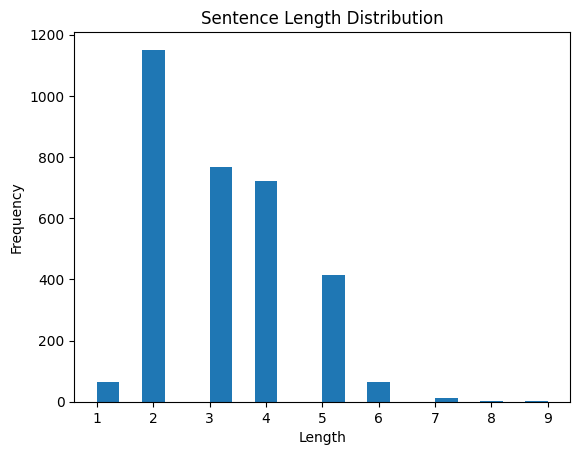

In [18]:
import matplotlib.pyplot as plt

sentence_lengths = [len(sentence.split()) for sentence in all_texts]  # Replace with your data
plt.hist(sentence_lengths, bins=20)
plt.title("Sentence Length Distribution")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.show()


In [19]:
sentence_lengths = [len(sentence.split()) for sentence in all_texts]
coverage = [sum(l <= seq_len for l in sentence_lengths) / len(sentence_lengths) for seq_len in range(1, 11)]
for seq_len, cov in enumerate(coverage, 1):
    print(f"Max Seq Len: {seq_len}, Coverage: {cov*100:.2f}%")


Max Seq Len: 1, Coverage: 2.00%
Max Seq Len: 2, Coverage: 37.97%
Max Seq Len: 3, Coverage: 62.00%
Max Seq Len: 4, Coverage: 84.56%
Max Seq Len: 5, Coverage: 97.47%
Max Seq Len: 6, Coverage: 99.50%
Max Seq Len: 7, Coverage: 99.88%
Max Seq Len: 8, Coverage: 99.97%
Max Seq Len: 9, Coverage: 100.00%
Max Seq Len: 10, Coverage: 100.00%


In [20]:
# Define model parameters
dim = 128
depth = 2
num_epochs = 20  # Increased number of epochs for better training
batch_size = 16
learning_rate = 3e-4  # Adjusted learning rate ; 3e-4 not bad
head_num = 4

In [21]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [22]:
# Lists to store results
losses = []
times = []
epoch_losses = []
gradient_norms = []

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TransformerLM(vocab_size, dim, depth, max_seq_len, head_num, dropout=0.1).to(device)

# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)  # Learning rate scheduler

# Generate dummy data for the given sequence length
ids = torch.randint(0, vocab_size, (batch_size, max_seq_len * 100)).to(device)  # Adjust size as needed
num_batches = ids.size(1) // max_seq_len

print(f"Sequence Length: {max_seq_len}, Num Batches: {num_batches}")

# Train the model
start_time = time.time()
total_loss = 0

for epoch in range(num_epochs):
    epoch_loss = 0
    model.train()  # Ensure the model is in training mode
    for i in range(0, ids.size(1) - max_seq_len, max_seq_len):
        # Get mini-batches
        inputs = ids[:, i:i + max_seq_len].to(device)
        targets = ids[:, (i + 1):(i + 1) + max_seq_len].to(device)

        # Forward pass
        input_lengths = (torch.ones(batch_size) * max_seq_len).to(torch.int32)  # A tensor of the same length for each sequence
        outputs = model(inputs)  # Process TransformerLM's forward method
        output_flat = outputs.view(-1, vocab_size)  # Reshaped

        # Backward pass
        loss = criterion(output_flat, targets.reshape(-1))

        optimizer.zero_grad()
        loss.backward()

        # Calculate gradient norm
        total_norm = 0
        for param in model.parameters():
            if param.grad is not None:
                param_norm = param.grad.data.norm(2)
                total_norm += param_norm.item() ** 2
        total_norm = total_norm ** 0.5
        gradient_norms.append(total_norm)

        clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        epoch_loss += loss.item()

    epoch_losses.append(epoch_loss / num_batches)
    scheduler.step(epoch_loss / num_batches)  # Adjust learning rate based on validation loss

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss / num_batches}")

elapsed_time = time.time() - start_time
avg_loss = total_loss / (num_batches * num_epochs)
losses.append(avg_loss)
times.append(elapsed_time)

print(f"Sequence Length: {max_seq_len}, Avg Loss: {avg_loss}, Time: {elapsed_time}")

Sequence Length: 5, Num Batches: 100
Epoch 1/20, Loss: 7.7024123573303225
Epoch 2/20, Loss: 7.520085144042969
Epoch 3/20, Loss: 7.311089887619018
Epoch 4/20, Loss: 7.0785953187942505
Epoch 5/20, Loss: 6.810819449424744
Epoch 6/20, Loss: 6.5015155839920045
Epoch 7/20, Loss: 6.1480703973770146
Epoch 8/20, Loss: 5.757157740592956
Epoch 9/20, Loss: 5.336379690170288
Epoch 10/20, Loss: 4.892797060012818
Epoch 11/20, Loss: 4.423728873729706
Epoch 12/20, Loss: 3.9484826827049258
Epoch 13/20, Loss: 3.471491460800171
Epoch 14/20, Loss: 2.9975705575942992
Epoch 15/20, Loss: 2.5454015278816224
Epoch 16/20, Loss: 2.11982913851738
Epoch 17/20, Loss: 1.7337144029140472
Epoch 18/20, Loss: 1.3878335499763488
Epoch 19/20, Loss: 1.1059815406799316
Epoch 20/20, Loss: 0.8707897633314132
Sequence Length: 5, Avg Loss: 4.483187306374312, Time: 36.85336899757385


In [24]:
def tokenize(sentence, vectorization):
    """
    Tokenizes a sentence into token IDs using the given vectorization model.

    Args:
        sentence (str): The input sentence.
        vectorization: A vectorization object to tokenize the sentence.

    Returns:
        list: A list of token IDs for the given sentence.
    """
    return vectorization(sentence).numpy()


In [ ]:
# Reverse vocabulary for detokenization
vocabulary = eng_vectorization.get_vocabulary()  # Returns a list of tokens
reverse_vocab = {index: token for index, token in enumerate(vocabulary)}

# Test sentences
spanish_sentences = [
    "¿Tienes hermanos o hermanas?",
    "Si nos levantamos lo suficientemente temprano, podremos ver el amanecer."
]

# Tokenize input sentences
tokenized_inputs = [tokenize(sentence, spa_vectorization) for sentence in spanish_sentences]
input_tensors = torch.tensor(tokenized_inputs).to(device)

# Add SOS token and pad the inputs to max_seq_len
sos_token = eng_vectorization("<start>").numpy()[0]
eos_token = eng_vectorization("<end>").numpy()[0]
input_tensors = torch.cat(
    [torch.full((len(input_tensors), 1), sos_token, device=device), input_tensors],
    dim=1
)

# Translation loop
model.eval()
translated_sentences = []
for input_tensor in input_tensors:
    input_tensor = input_tensor.unsqueeze(0)  # Add batch dimension
    decoder_input = torch.tensor([[sos_token]], device=device)  # Start with SOS token

    for _ in range(max_seq_len):
        # Forward pass through the model
        predictions = model(input_tensor)
        predicted_token = torch.argmax(predictions, dim=-1)[:, -1].item()  # Get the last predicted token

        if predicted_token == eos_token:
            break
        decoder_input = torch.cat([decoder_input, torch.tensor([[predicted_token]], device=device)], dim=1)

    # Detokenize the output sequence
    translated_sentence = detokenize(decoder_input[0].cpu().numpy(), reverse_vocab)
    translated_sentences.append(translated_sentence)

# Print results
for i, sentence in enumerate(spanish_sentences):
    print(f"Spanish: {sentence}")
    print(f"English: {translated_sentences[i]}")
    print()
